# Spooky Author Identification
<hr style="border:2px solid turquoise">

The challenge: can you predict the author of the excerpt from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft? 

https://www.kaggle.com/c/spooky-author-identification/overview

The data contains the following: 
- id - a unique identifier for each sentence
- text - some text written by one of the authors
- author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

First, let's import the necessary packages and load in the data. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import string
import re

%matplotlib inline

In [2]:
test = pd.read_csv('../Data/test/test.csv')
train = pd.read_csv('../Data/train/train.csv')

Let's do a quick visual to make sure they loaded properly.  

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


The train file has 19,579 rows with no missing values. Contains ID, text, and author, all object data types, which makes sense. Let's look at the test data. 

In [5]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8392 non-null   object
 1   text    8392 non-null   object
dtypes: object(2)
memory usage: 131.2+ KB


The test file has 8,392 rows with no nulls. Contains only ID and text, so we will need to predict the author. 

Let's explore the train file and leave the test file as is until testing the models.

# Data Exploration

First, let's confirm there are no missing values in the train file. 

In [7]:
# no missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [8]:
# confirmed no missing values
train.isna().sum()

id        0
text      0
author    0
dtype: int64

Great! Let's check out a few basic statistics on the train file. 

In [9]:
# each row has unique id, text, and the author
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [10]:
train.shape

(19579, 3)

In [11]:
# check out the distribution of the authors
train['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [12]:
# check out the %
train['author'].value_counts(normalize=True)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

So the file contains the most excerpts from EAP (40%), followed by MWS (31%), and then HPL (29%). As this is slightly imbalanced, it could be interesting to see how changing the weights of the classes impacts modeling later on. 

Let's visualize the distribution. 

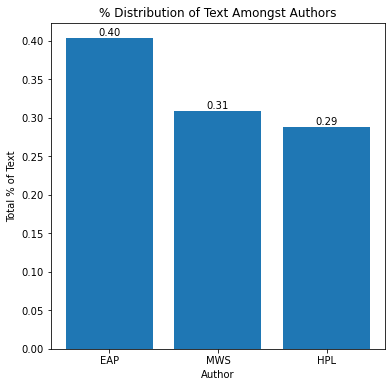

In [13]:
# plot it
fig, ax = plt.subplots(figsize=(6,6))
plt.bar(train['author'].value_counts(normalize=True).index, train['author'].value_counts(normalize=True).values)
plt.xlabel('Author')
plt.ylabel('Total % of Text')
plt.title('% Distribution of Text Amongst Authors')

# add counts to the top of the bars
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.2f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show();

Note that I will need to change the labels from EAP, MWS, and HPL to 0, 1, and 2 via one hot encoding during the cleaning process next. 

In [14]:
# check out the text and author sample
train.loc[10].text

'He shall find that I can feel my injuries; he shall learn to dread my revenge" A few days after he arrived.'

In [15]:
train.loc[10].author

'MWS'

Will need to remove punctuation, lowercase everything, remove numbers, and remove stopwords to clean (in addition to changing the labels). 

# Text Cleaning and Preprocessing

I will preprocess and clean the data by: 
1. tokenizing it: splitting up the text by word or sentence. By word gives you useful words, by sentence gives you more context.
2. remove capitalization
3. remove punctuation
4. remove numbers
5. remove stopwords
6. one hot encoding the labels

First, tokenize the list. 

In [16]:
def tokenize(text):
    tokens = word_tokenize(text)
    return tokens

train['clean_text'] = train['text'].apply(lambda x: tokenize(x))

In [17]:
train.head()

,id,text,author,clean_text
0,id26305,"This process, however, afforded me no means of...",EAP,"[This, process, ,, however, ,, afforded, me, n..."
1,id17569,It never once occurred to me that the fumbling...,HPL,"[It, never, once, occurred, to, me, that, the,..."
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,"[In, his, left, hand, was, a, gold, snuff, box..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,"[How, lovely, is, spring, As, we, looked, from..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,"[Finding, nothing, else, ,, not, even, gold, ,..."


Next, remove capitalization. 

In [18]:
def lowercase(text):
    lower = [word.lower() for word in text]
    return lower

train['clean_text'] = train['clean_text'].apply(lambda x: lowercase(x))

In [19]:
train.head()

,id,text,author,clean_text
0,id26305,"This process, however, afforded me no means of...",EAP,"[this, process, ,, however, ,, afforded, me, n..."
1,id17569,It never once occurred to me that the fumbling...,HPL,"[it, never, once, occurred, to, me, that, the,..."
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,"[in, his, left, hand, was, a, gold, snuff, box..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,"[how, lovely, is, spring, as, we, looked, from..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,"[finding, nothing, else, ,, not, even, gold, ,..."


Next, remove punctuation. 

In [20]:
def remove_punctuation(text):
    no_punctuation = [x for x in text if x not in string.punctuation]
    return no_punctuation

train['clean_text'] = train['clean_text'].apply(lambda x: remove_punctuation(x))

In [21]:
train.head()

,id,text,author,clean_text
0,id26305,"This process, however, afforded me no means of...",EAP,"[this, process, however, afforded, me, no, mea..."
1,id17569,It never once occurred to me that the fumbling...,HPL,"[it, never, once, occurred, to, me, that, the,..."
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,"[in, his, left, hand, was, a, gold, snuff, box..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,"[how, lovely, is, spring, as, we, looked, from..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,"[finding, nothing, else, not, even, gold, the,..."


Next, remove stopwords 

In [23]:
# review what the stopwords are
stopwords.words('English')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [24]:
def remove_stopwords(text):
    no_stopwords = [token for token in text if token not in stopwords.words('english')]
    return no_stopwords

train['clean_text'] = train['clean_text'].apply(lambda x: remove_stopwords(x))

In [25]:
train.head()

,id,text,author,clean_text
0,id26305,"This process, however, afforded me no means of...",EAP,"[process, however, afforded, means, ascertaini..."
1,id17569,It never once occurred to me that the fumbling...,HPL,"[never, occurred, fumbling, might, mere, mistake]"
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,"[left, hand, gold, snuff, box, capered, hill, ..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,"[lovely, spring, looked, windsor, terrace, six..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,"[finding, nothing, else, even, gold, superinte..."
